<a href="https://colab.research.google.com/github/ClaireLouiseR/COMP8420/blob/main/notebooks/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from torchvision import models
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import copy


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

USE_RESNET = False

cuda


In [ ]:
# Paths
ROOT_DIR = "/content/drive/MyDrive/faces-emotion_v2"
TRAIN_PATH = os.path.join(ROOT_DIR, "train_split")
VAL_PATH = os.path.join(ROOT_DIR, "val_split")
TEST_PATH = os.path.join(ROOT_DIR, "test_split")

def compute_mean_std(loader):
    """
    Compute the mean and standard deviation of the dataset.
    """
    # Initialise lists to store per-channel sum, sum of squares, and number of pixels
    channel_sum = torch.zeros(3)
    channel_sum_squared = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        # Update per-channel sum and sum of squares
        channel_sum += torch.sum(images, dim=[0, 2, 3])
        channel_sum_squared += torch.sum(images**2, dim=[0, 2, 3])
        num_pixels += images.numel() // 3  # Number of pixels in the batch

    # Calculate mean and standard deviation
    mean = channel_sum / num_pixels
    std = (channel_sum_squared / num_pixels - mean**2)**0.5

    return mean, std

def get_transforms(mean, std):
    transform_train = transforms.Compose([
        # Resize
        transforms.Resize((256, 256)),

        # Random horizontal flip
        transforms.RandomHorizontalFlip(),

        # Random rotation
        transforms.RandomRotation(10),

        # Brightness, Contrast, and Saturation adjustments
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

        # Gaussian Blur
        #transforms.GaussianBlur(3, sigma=(0.1, 2.0)),

        # Convert to tensor
        transforms.ToTensor(),

        # Normalise
        transforms.Normalize(mean, std)
    ])

    transform_val_test = transforms.Compose([
        # Resize
        transforms.Resize((256, 256)),

        # Convert to tensor
        transforms.ToTensor(),

        # Normalise
        transforms.Normalize(mean, std)
    ])

    return transform_train, transform_val_test

def create_data_loaders():

    # Create an initial loader to compute mean and std without any normalisation
    initial_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    initial_dataset = datasets.ImageFolder(TRAIN_PATH, transform=initial_transform)
    initial_loader = DataLoader(initial_dataset, batch_size=16, shuffle=False, num_workers=2)

    # Compute mean and standard deviation
    mean, std = compute_mean_std(initial_loader)

    # Get the appropriate transforms
    transform_train, transform_val_test = get_transforms(mean, std)

    # Create the datasets with the computed normalisation
    train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform_train)
    val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform_val_test)
    test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform_val_test)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # MaxPooling Layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Batch Normalisation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        # Layer 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Layer 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Layer 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flattening the layer
        x = x.view(-1, 128 * 32 * 32)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x



# Instantiate the model
model = EmotionCNN().to(device)  # Move model to GPU

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=weight_decay)


In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return average_loss, accuracy


def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0

    with torch.no_grad():  # No gradient computation during evaluation
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return average_loss, accuracy

def plot_confusion_matrix(y_true, y_pred, classes):
    matrix = confusion_matrix(y_true, y_pred)
    # Normalise by row (i.e., by true class)
    matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    matrix_percentage = matrix_normalized * 100  # Convert to percentage
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap='Greens', ax=ax, cbar=False,
                xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

def evaluate_on_test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    # Plot confusion matrix
    class_names = test_loader.dataset.classes
    plot_confusion_matrix(all_labels, all_preds, class_names)


In [ ]:
def show_transformed_images(dataset, images_per_class=10):
    class_counts = {}
    images_to_show = []
    labels_to_show = []

    for img, label in dataset:
        # Update count for the current class
        class_counts[label] = class_counts.get(label, 0) + 1

        # Only process if we haven't seen the class 10 times yet
        if class_counts[label] <= images_per_class:
            # Inverse normalise the image for display
            img = img / 2 + 0.5
            img = img.clamp(0, 1)  # Ensure values are in [0, 1]
            images_to_show.append(img)
            labels_to_show.append(label)

        # Stop if we've seen each class 10 times
        if len(class_counts) == len(dataset.classes) and all(count == images_per_class for count in class_counts.values()):
            break

    # Calculate number of rows and columns for display
    num_rows = len(dataset.classes)
    num_cols = images_per_class

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            idx = i * images_per_class + j
            img_np = images_to_show[idx].numpy().transpose((1, 2, 0))
            ax.imshow(img_np)
            # Set title for the first image in each row
            if j == 0:
                ax.set_title(dataset.classes[labels_to_show[idx]])
            ax.axis('off')

    # Adjust the vertical space between rows
    plt.subplots_adjust(hspace=0.0)
    plt.tight_layout()
    plt.show()


In [ ]:

if __name__ == "__main__":
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_data_loaders()
    show_transformed_images(train_dataset)
    if USE_RESNET:
        # Load a pre-trained ResNet and modify the last layer
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 7)  # 7 classes
    else:
        model = EmotionCNN()

    model = model.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
    num_epochs = 50

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate(model, val_loader, criterion)

        # Update learning rate based on validation loss
        # scheduler.step(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)

    evaluate_on_test(model, test_loader)






Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994423870a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7994423870a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 1/40
Train Loss: 1.9821, Train Accuracy: 15.68%
Validation Loss: 1.9288, Validation Accuracy: 11.94%
------------------------------
Epoch 2/40
Train Loss: 1.9265, Train Accuracy: 18.86%
Validation Loss: 1.9050, Validation Accuracy: 20.90%
------------------------------
Epoch 3/40
Train Loss: 1.8578, Train Accuracy: 25.21%
Validation Loss: 1.8902, Validation Accuracy: 23.88%
------------------------------
Epoch 4/40
Train Loss: 1.8186, Train Accuracy: 29.87%
Validation Loss: 1.8744, Validation Accuracy: 23.88%
------------------------------
Epoch 5/40
Train Loss: 1.7928, Train Accuracy: 31.36%
Validation Loss: 1.8575, Validation Accuracy: 28.36%
------------------------------
Epoch 6/40
Train Loss: 1.7530, Train Accuracy: 33.47%
Validation Loss: 1.8391, Validation Accuracy: 26.87%
------------------------------
Epoch 7/40
Train Loss: 1.7191, Train Accuracy: 36.44%
Validation Loss: 1.8252, Validation Accuracy: 29.85%
------------------------------
Epoch 8/40
Train Loss: 1.6374, Tra

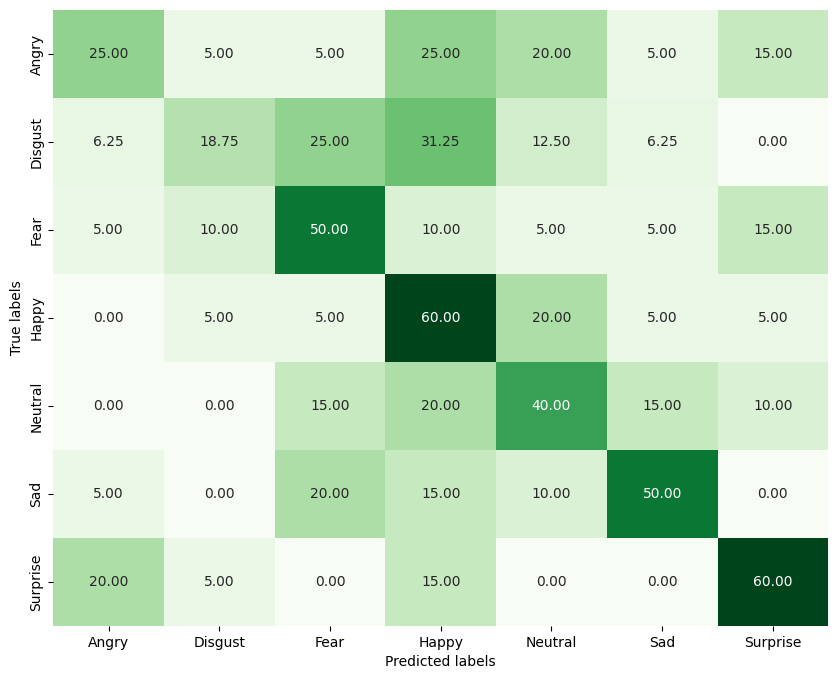

In [ ]:
# Fine tuning
if __name__ == "__main__":
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_data_loaders()

    # Load a pre-trained VGG-16 model
    model = models.vgg16(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer to match the number of classes in the FER dataset
    num_classes = 7
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    # Unfreeze the fully connected layers (classifier part) for fine-tuning
    for param in model.classifier.parameters():
        param.requires_grad = True

    model = model.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
    num_epochs = 40

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate(model, val_loader, criterion)

        # Update learning rate based on validation loss
        # scheduler.step(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)

    evaluate_on_test(model, test_loader)
